<a href="https://colab.research.google.com/github/Bagito999/Deep-Learning/blob/main/DeteksiSarkasme_RNN_LSTM_GRU_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Model Deep Learning RNN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json

In [2]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load dataset
with open("/content/drive/MyDrive/Deep Learning/DeteksiSarkasme.json", 'r') as f:
    data = [json.loads(line) for line in f]
df = pd.DataFrame(data)
df = df[['headline', 'is_sarcastic']].dropna()

# Cek distribusi label
print("Label Distribution:\n", df['is_sarcastic'].value_counts())

# Tokenisasi
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['headline'])
X = tokenizer.texts_to_sequences(df['headline'])
X = pad_sequences(X, maxlen=30, padding='post')
y = df['is_sarcastic'].values

# Split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Device: cuda
Label Distribution:
 is_sarcastic
0    14985
1    11724
Name: count, dtype: int64


In [3]:
# Tensor
x_train_tensor = torch.tensor(x_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Dataset & Loader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

# Hitung pos_weight untuk class imbalance
pos_weight_val = (len(y_train) - y_train.sum()) / y_train.sum()
pos_weight = torch.tensor([pos_weight_val]).to(device)

In [4]:
# RNN Model
class SarcasmRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SarcasmRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=2, batch_first=True,
                          bidirectional=True, nonlinearity='relu')
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.rnn(x)
        h_n = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        x = torch.relu(self.fc1(h_n))
        x = self.dropout(x)
        x = self.fc2(x)
        return torch.sigmoid(x).view(-1)

# Inisialisasi model
vocab_size = len(tokenizer.word_index) + 1
model = SarcasmRNN(vocab_size, embedding_dim=128, hidden_dim=256, output_dim=1).to(device)

# Loss & optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [5]:
# Training
epochs = 10
train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = [], [], [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct = 0, 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = (outputs >= 0.5).float()
        correct += (preds == y_batch).sum().item()

    train_acc = correct / len(train_dataset)
    train_loss = total_loss / len(train_loader)
    train_acc_hist.append(train_acc)
    train_loss_hist.append(train_loss)

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds = (outputs >= 0.5).float()
            val_correct += (preds == y_batch).sum().item()

    val_acc = val_correct / len(test_dataset)
    val_loss_hist.append(val_loss / len(test_loader))
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/10 | Train Acc: 0.7013, Val Acc: 0.7439
Epoch 2/10 | Train Acc: 0.7913, Val Acc: 0.7752
Epoch 3/10 | Train Acc: 0.8270, Val Acc: 0.7973
Epoch 4/10 | Train Acc: 0.8404, Val Acc: 0.8081
Epoch 5/10 | Train Acc: 0.8640, Val Acc: 0.7885
Epoch 6/10 | Train Acc: 0.8762, Val Acc: 0.8156
Epoch 7/10 | Train Acc: 0.8870, Val Acc: 0.8149
Epoch 8/10 | Train Acc: 0.8961, Val Acc: 0.8184
Epoch 9/10 | Train Acc: 0.9020, Val Acc: 0.8233
Epoch 10/10 | Train Acc: 0.9030, Val Acc: 0.8205


In [7]:
# Evaluasi akhir
model.eval()
y_probs = []
with torch.no_grad():
    for x_batch, _ in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        y_probs.extend(outputs.cpu().numpy())

y_probs = np.array(y_probs)
y_preds = (y_probs >= 0.5).astype(int)

# Metrik
acc = accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1_sq = f1_score(y_test, y_preds) ** 2
auc = roc_auc_score(y_test, y_probs)

print(f"Improved RNN Results:")
print(f"Final Training Accuracy: {train_acc_hist[-1]:.4f}")
print(f"Final Testing Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Squared: {f1_sq:.4f}")
print(f"AUC: {auc:.4f}")

Improved RNN Results:
Final Training Accuracy: 0.9030
Final Testing Accuracy: 0.8205
Precision: 0.7900
Recall: 0.8052
F1 Squared: 0.6361
AUC: 0.9026


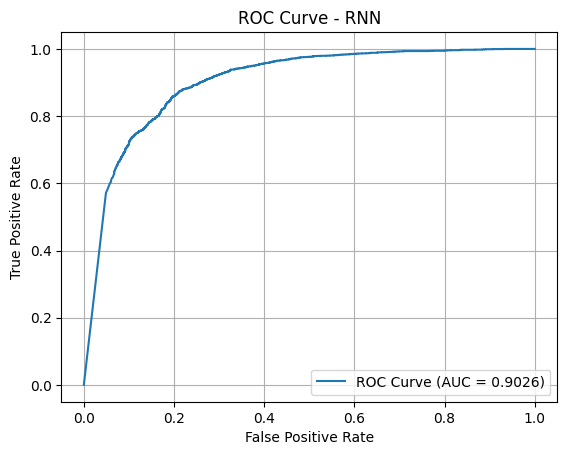

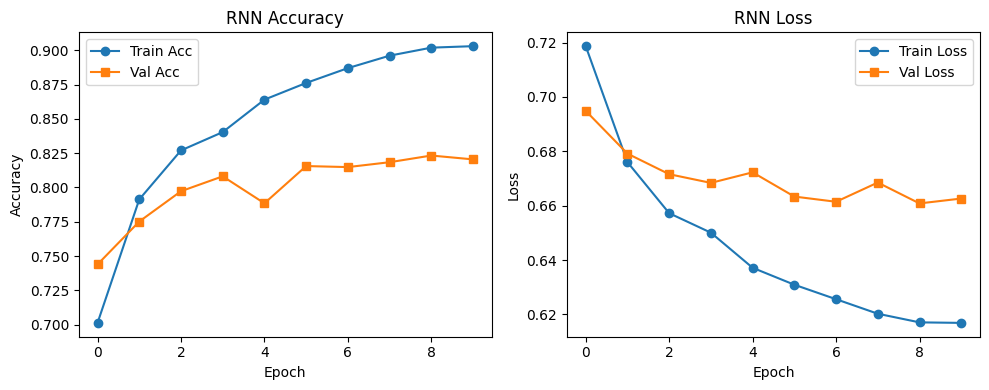

In [8]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RNN')
plt.legend()
plt.grid()
plt.show()

# Plot Akurasi & Loss
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc_hist, label='Train Acc', marker='o')
plt.plot(val_acc_hist, label='Val Acc', marker='s')
plt.title('RNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist, label='Train Loss', marker='o')
plt.plot(val_loss_hist, label='Val Loss', marker='s')
plt.title('RNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#Model Deep Learning LSTM

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json

In [10]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load dataset
with open("/content/drive/MyDrive/Deep Learning/DeteksiSarkasme.json", 'r') as f:
    data = [json.loads(line) for line in f]
df = pd.DataFrame(data)
df = df[['headline', 'is_sarcastic']].dropna()

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['headline'])
X = tokenizer.texts_to_sequences(df['headline'])
X = pad_sequences(X, maxlen=30, padding='post')
y = df['is_sarcastic'].values

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Dataloaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

Device: cuda


In [11]:
# LSTM Model
class SarcasmLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SarcasmLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        h_n = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        x = torch.relu(self.fc1(h_n))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x.view(-1)

# Initialize model
vocab_size = len(tokenizer.word_index) + 1
model = SarcasmLSTM(vocab_size, embedding_dim=128, hidden_dim=128, output_dim=1).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Training
epochs = 10
train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = [], [], [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct = 0, 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((outputs >= 0.5).float() == y_batch).sum().item()

    train_acc = correct / len(train_dataset)
    train_loss = total_loss / len(train_loader)
    train_acc_hist.append(train_acc)
    train_loss_hist.append(train_loss)

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            val_correct += ((outputs >= 0.5).float() == y_batch).sum().item()

    val_acc = val_correct / len(test_dataset)
    val_loss_hist.append(val_loss / len(test_loader))
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/10 | Train Acc: 0.7436, Val Acc: 0.8025
Epoch 2/10 | Train Acc: 0.8619, Val Acc: 0.8368
Epoch 3/10 | Train Acc: 0.9174, Val Acc: 0.8439
Epoch 4/10 | Train Acc: 0.9545, Val Acc: 0.8420
Epoch 5/10 | Train Acc: 0.9796, Val Acc: 0.8424
Epoch 6/10 | Train Acc: 0.9910, Val Acc: 0.8411
Epoch 7/10 | Train Acc: 0.9938, Val Acc: 0.8405
Epoch 8/10 | Train Acc: 0.9948, Val Acc: 0.8422
Epoch 9/10 | Train Acc: 0.9941, Val Acc: 0.8381
Epoch 10/10 | Train Acc: 0.9963, Val Acc: 0.8435


In [13]:
# Final evaluation
model.eval()
y_probs = []
with torch.no_grad():
    for x_batch, _ in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        y_probs.extend(outputs.cpu().numpy())

y_probs = np.array(y_probs)
y_preds = (y_probs >= 0.5).astype(int)

# Metrics
acc = accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1_sq = f1_score(y_test, y_preds) ** 2
auc = roc_auc_score(y_test, y_probs)

print(f"LSTM Results:")
print(f"Final Training Accuracy: {train_acc_hist[-1]:.4f}")
print(f"Final Testing Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Squared: {f1_sq:.4f}")
print(f"AUC: {auc:.4f}")

LSTM Results:
Final Training Accuracy: 0.9963
Final Testing Accuracy: 0.8435
Precision: 0.8404
Recall: 0.7945
F1 Squared: 0.6672
AUC: 0.9209


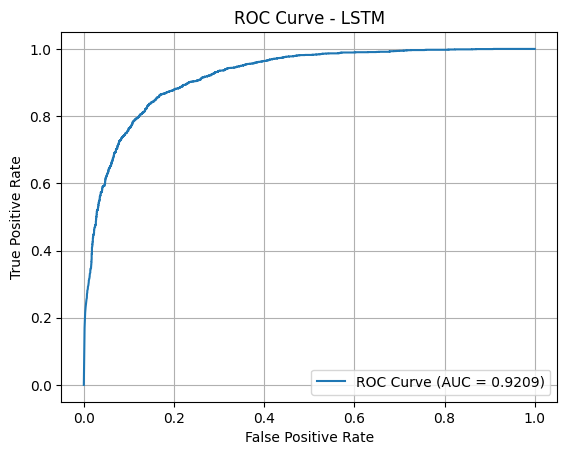

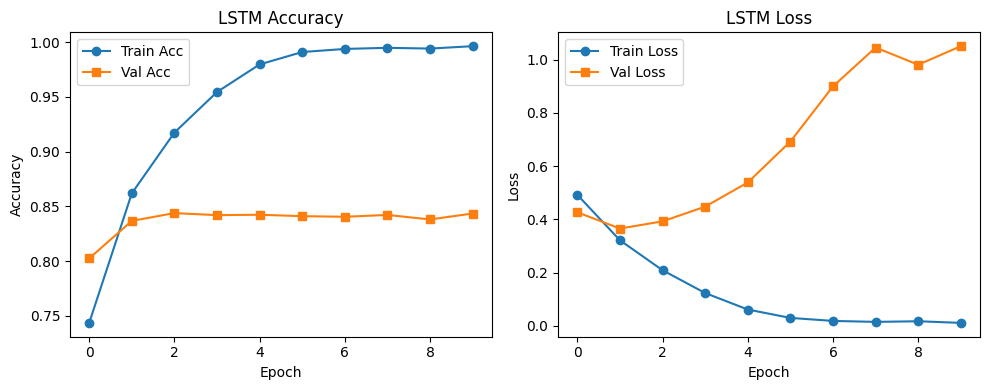

In [14]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM')
plt.legend()
plt.grid()
plt.show()

# Accuracy & Loss Plots
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc_hist, label='Train Acc', marker='o')
plt.plot(val_acc_hist, label='Val Acc', marker='s')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist, label='Train Loss', marker='o')
plt.plot(val_loss_hist, label='Val Loss', marker='s')
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#Model Deep Learning GRU

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json

In [16]:
# Cek device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load dataset
with open("/content/drive/MyDrive/Deep Learning/DeteksiSarkasme.json", 'r') as f:
    data = [json.loads(line) for line in f]
df = pd.DataFrame(data)
df = df[['headline', 'is_sarcastic']].dropna()

# Tokenisasi dan padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['headline'])
X = tokenizer.texts_to_sequences(df['headline'])
X = pad_sequences(X, maxlen=30, padding='post')
y = df['is_sarcastic'].values

# Split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert ke tensor
x_train_tensor = torch.tensor(x_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Dataset & DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

Device: cuda


In [17]:
# GRU Model
class SarcasmGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SarcasmGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.gru(x)
        h_n = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        x = torch.relu(self.fc1(h_n))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x.view(-1)

# Inisialisasi model
vocab_size = len(tokenizer.word_index) + 1
model = SarcasmGRU(vocab_size, embedding_dim=128, hidden_dim=128, output_dim=1).to(device)

# Loss dan Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
# Training
epochs = 10
train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = [], [], [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct = 0, 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((outputs >= 0.5).float() == y_batch).sum().item()

    train_acc = correct / len(train_dataset)
    train_loss = total_loss / len(train_loader)
    train_acc_hist.append(train_acc)
    train_loss_hist.append(train_loss)

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            val_correct += ((outputs >= 0.5).float() == y_batch).sum().item()

    val_acc = val_correct / len(test_dataset)
    val_loss_hist.append(val_loss / len(test_loader))
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/10 | Train Acc: 0.9986, Val Acc: 0.8450
Epoch 2/10 | Train Acc: 0.9980, Val Acc: 0.8433
Epoch 3/10 | Train Acc: 0.9993, Val Acc: 0.8497
Epoch 4/10 | Train Acc: 0.9997, Val Acc: 0.8506
Epoch 5/10 | Train Acc: 0.9997, Val Acc: 0.8489
Epoch 6/10 | Train Acc: 0.9998, Val Acc: 0.8497
Epoch 7/10 | Train Acc: 0.9998, Val Acc: 0.8491
Epoch 8/10 | Train Acc: 0.9998, Val Acc: 0.8499
Epoch 9/10 | Train Acc: 0.9998, Val Acc: 0.8495
Epoch 10/10 | Train Acc: 0.9997, Val Acc: 0.8495


In [21]:
# Evaluasi akhir
model.eval()
y_probs = []
with torch.no_grad():
    for x_batch, _ in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        y_probs.extend(outputs.cpu().numpy())

y_probs = np.array(y_probs)
y_preds = (y_probs >= 0.5).astype(int)

# Metrik
acc = accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1_sq = f1_score(y_test, y_preds) ** 2
auc = roc_auc_score(y_test, y_probs)

print(f"\nGRU Results:")
print(f"Final Training Accuracy: {train_acc_hist[-1]:.4f}")
print(f"Final Testing Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Squared: {f1_sq:.4f}")
print(f"AUC: {auc:.4f}")


GRU Results:
Final Training Accuracy: 0.9997
Final Testing Accuracy: 0.8495
Precision: 0.8391
Recall: 0.8133
F1 Squared: 0.6822
AUC: 0.9208


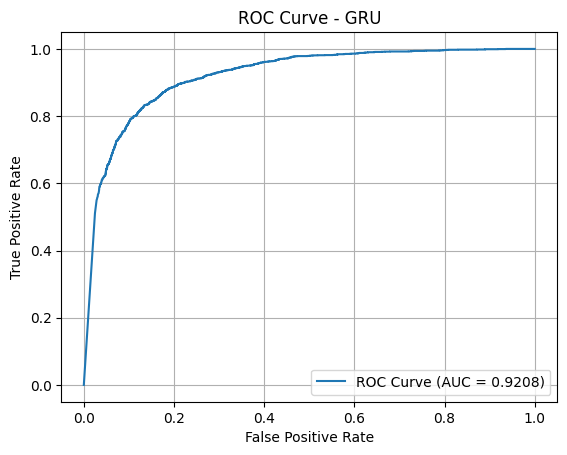

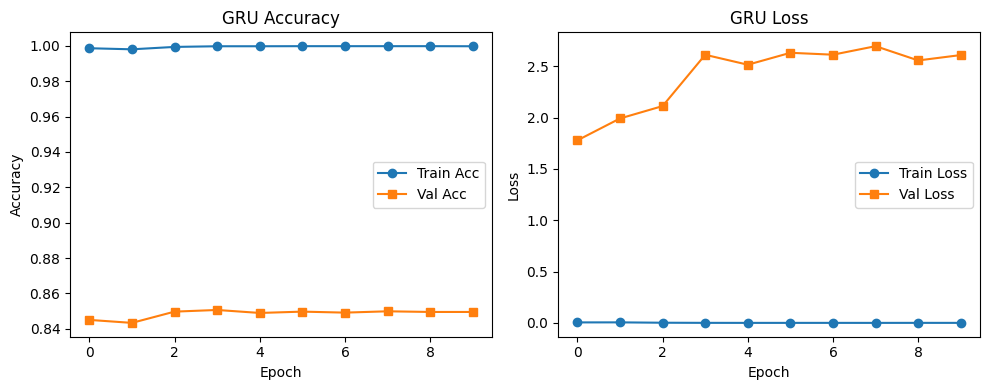

In [22]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - GRU')
plt.legend()
plt.grid()
plt.show()

# Accuracy & Loss
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc_hist, label='Train Acc', marker='o')
plt.plot(val_acc_hist, label='Val Acc', marker='s')
plt.title('GRU Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist, label='Train Loss', marker='o')
plt.plot(val_loss_hist, label='Val Loss', marker='s')
plt.title('GRU Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 📘 Penjelasan Persamaan Matematika dalam Deep Learning

---

## 🔁 1. Recurrent Neural Network (RNN)

Model RNN mempertimbangkan urutan dengan memori internal:

\[
$h_t = \tanh(W_h h_{t-1} + W_x x_t + b)$
\]

- \($ h_t $\): Hidden state saat waktu \($ t $\)
- \($ x_t $\): Input saat waktu \($ t $\)
- \($ W_h, W_x $\): Bobot hidden dan input
- \($ b $\): Bias

---

## 🔒 2. Long Short-Term Memory (LSTM)

LSTM memiliki mekanisme gate untuk menangani long-term dependency:

\[
\begin{aligned}
f_t &= \sigma(W_f [h_{t-1}, x_t] + b_f) \quad \text{(forget gate)} \\
i_t &= \sigma(W_i [h_{t-1}, x_t] + b_i) \quad \text{(input gate)} \\
\tilde{C}_t &= \tanh(W_C [h_{t-1}, x_t] + b_C) \quad \text{(candidate state)} \\
C_t &= f_t * C_{t-1} + i_t * \tilde{C}_t \quad \text{(cell state)} \\
o_t &= \sigma(W_o [h_{t-1}, x_t] + b_o) \quad \text{(output gate)} \\
h_t &= o_t * \tanh(C_t) \quad \text{(hidden state)}
\end{aligned}
\]

---

## 🔁 3. Gated Recurrent Unit (GRU)

GRU adalah versi lebih sederhana dari LSTM:

\[
\begin{aligned}
z_t &= \sigma(W_z [h_{t-1}, x_t]) \quad \text{(update gate)} \\
r_t &= \sigma(W_r [h_{t-1}, x_t]) \quad \text{(reset gate)} \\
\tilde{h}_t &= \tanh(W [r_t * h_{t-1}, x_t]) \quad \text{(candidate state)} \\
h_t &= (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t \quad \text{(new state)}
\end{aligned}
\]

---

## 📉 4. Binary Cross-Entropy Loss

Untuk klasifikasi biner, fungsi loss adalah:

\[
\$mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \left[y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right]
$\]

- \($ y_i $\): Label sebenarnya (0 atau 1)
- \($ \hat{y}_i $\): Prediksi model

---

## 🧮 5. Evaluasi Model

**Akurasi:**

\[
$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$
\]

Keterangan:
- **TP** = True Positive
- **TN** = True Negative
- **FP** = False Positive
- **FN** = False Negative

**Presisi:**

\[$
\text{Precision} = \frac{TP}{TP + FP}
$\]

**Recall:**

\[$
\text{Recall} = \frac{TP}{TP + FN}
$\]

**F1 Score:**

\[$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$\]

**F1 Squared:**

\[$
F1^2 = (F1)^2
$\]

**AUC (Area Under Curve):** Luas di bawah kurva ROC yang menggambarkan trade-off antara TPR dan FPR.

**ROC Curve:** Grafik yang menunjukkan hubungan antara TPR (True Positive Rate) dan FPR (False Positive Rate).

---

